# Wheat Stripe Rust Disease Classification

## Training & Model Comparison (Transfer Learning) - Optimized Models

In [1]:
# Import necessary libraries for data manipulation and handling
import numpy as np
import pandas as pd
import os

# Import PyTorch and its submodules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim

# Import torchvision for computer vision tasks
from torchvision import datasets, models, transforms

# Import PyTorch classes and functions for data loading
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Import specific pre-trained models from torchvision
from torchvision.models import resnet18, resnet50, densenet161, alexnet

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import scikit-learn for machine learning-related metrics and tools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns

C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Set the random seed for PyTorch to ensure reproducibility
torch.manual_seed(159)

In [3]:
# Dataset_C was the final dataset that had original self collected data, and also datasets obtained from the internet
dataset_path = "./Dataset_C"
#dataset_path = "./grab_cut_data"

In [4]:
# Define a data transformation pipeline for training data
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),            # Resize the input image to 224x224 pixels
    transforms.RandomHorizontalFlip(),             # Apply random horizontal flips for data augmentation
    transforms.ToTensor(),                         # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using precomputed mean values
                         std=[0.229, 0.224, 0.225])  #   and standard deviations for ResNet18
])

# Define a data transformation pipeline for testing/validation data
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),            # Resize the input image to 224x224 pixels
    transforms.ToTensor(),                         # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using precomputed mean values
                         std=[0.229, 0.224, 0.225])  #   and standard deviations for ResNet18
])

# Create a dictionary to associate these transformations with dataset splits (train and test)
train_test_transform = {'train': train_transform, 'test': test_transform}

In [5]:
# Create a test dataset using the 'ImageFolder' class from the 'datasets' module
# - 'dataset_path': The path to the directory containing the test images.
# - 'transform': Apply the specified transformation pipeline for testing data.
testset = datasets.ImageFolder(dataset_path, transform=train_test_transform['test'])


In [6]:
def split_image_data(data_path, transform_dict):
    """
    Splits an image dataset into training and testing sets and creates data loaders.

    Args:
    - data_path (str): The path to the directory containing the image dataset.
    - transform_dict (dict): A dictionary containing transformation pipelines for 'train' and 'test' data.

    Returns:
    - trainloader (DataLoader): DataLoader for the training set.
    - testloader (DataLoader): DataLoader for the testing set.
    """
    # Create a training dataset with specified transformations
    trainset = datasets.ImageFolder(data_path, transform=transform_dict['train'])
    
    # Create a testing dataset with specified transformations
    testset = datasets.ImageFolder(data_path, transform=transform_dict['test'])
    
    # Calculate the number of test images (20% of the training set)
    num_test_imgs = int(np.floor(0.20 * len(trainset)))
    
    # Create a shuffled index of the training dataset
    idx = list(range(len(trainset)))
    np.random.shuffle(idx)
    
    # Define samplers for training and testing data
    train_sampler = SubsetRandomSampler(idx[num_test_imgs:])
    test_sampler = SubsetRandomSampler(idx[:num_test_imgs])
    
    # Create DataLoader instances for training and testing data
    # with batch size of 5
    trainloader = DataLoader(trainset, sampler=train_sampler, batch_size=5)
    testloader = DataLoader(testset, sampler=test_sampler, batch_size=5)
    
    return trainloader, testloader


In [7]:
# Create DataLoader objects for the training and testing datasets
# by calling the 'split_image_data' function with the dataset path and transformation dictionary.
trainloader, testloader = split_image_data(dataset_path, train_test_transform)

In [8]:
# Calculate the number of batches in the training DataLoader.
num_batches = len(trainloader)

589

In [9]:
# Define a list of class names to represent different categories or labels in your dataset.
class_names = ['Healthy', 'Resistant', 'Susceptible']

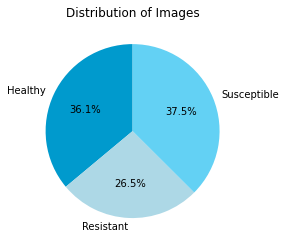

In [10]:
# Get a list of class names by listing directories in the dataset path.
class_names = os.listdir(dataset_path)

# Create a dictionary to store the count of images in each class.
image_count = {}

# Define a list of color palettes for the pie chart.
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', '#C1F0F6', '#0099CC']

# Loop through each class and count the number of images.
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(dataset_path, i)))

# Create a pie chart to visualize the distribution of images in each class.
fig1, ax1 = plt.subplots()
plt.title("Distribution of Images")
ax1.pie(image_count.values(),
        labels=image_count.keys(),
        shadow=False,
        autopct='%1.1f%%',
        startangle=90,
        colors=color_palette_list[0:3])  # Use a subset of the color palette for visibility.
plt.show()


<AxesSubplot:title={'center':'Image count by type'}>

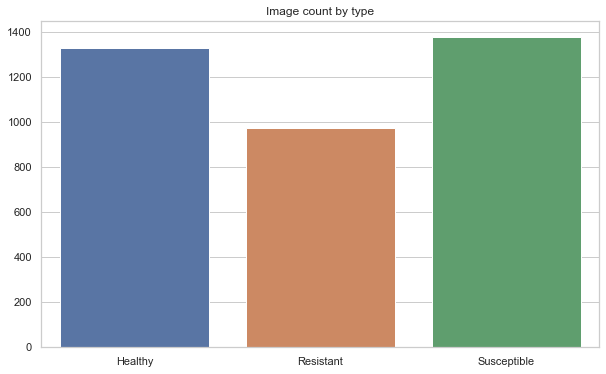

In [11]:
# Set the seaborn theme to 'whitegrid' for the plot.
sns.set_theme(style="whitegrid")

# Create a new figure for the plot with a specified size.
plt.figure(figsize=(10, 6))

# Set the title of the plot.
plt.title("Image count by type")

# Create a bar plot using seaborn to show the image count by type.
# - 'x' represents the class names (keys from the 'image_count' dictionary).
# - 'y' represents the corresponding image counts (values from the 'image_count' dictionary).
sns.barplot(x=list(image_count.keys()), y=list(image_count.values()))


## Resnet 18

In [12]:
# Initialize a ResNet-18 model with pre-trained weights.
model = resnet18(pretrained=True)

In [13]:
# Access the fully connected (classifier) layer of the ResNet-18 model.
fc_layer = model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [14]:
# Modify the fully connected (classifier) layer of the model.
model.fc = torch.nn.Linear(in_features=512, out_features=3)

# Initialize the Cross-Entropy Loss function.
loss_fn = torch.nn.CrossEntropyLoss()

- `model.fc = torch.nn.Linear(in_features=512, out_features=3)` modifies the fully connected layer of the model. Here, you are replacing the existing fully connected layer with a new one created using `torch.nn.Linear`. This new layer has 512 input features (which is typical for a ResNet-18 model) and 3 output features, which suggests that you are adapting the model for a classification task with three classes.

- `loss_fn = torch.nn.CrossEntropyLoss()` initializes the Cross-Entropy Loss function. Cross-Entropy Loss is commonly used for classification tasks, and it measures the dissimilarity between predicted class probabilities and actual class labels. It's a suitable choice when training a model for a multi-class classification task like the one you're configuring with 3 output classes.

In [15]:
# Load the state dictionary (weights and parameters) of the model from a saved checkpoint.
model.load_state_dict(torch.load("resnet18_dataC_model.pt"))

<All keys matched successfully>

In [16]:
# Check if a CUDA-compatible GPU is available; use it if available, otherwise use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device (either CUDA/GPU or CPU).
model = model.to(device)

- `torch.cuda.is_available()` checks if a CUDA-compatible GPU is available on the system. If one is available, it sets `device` to 'cuda,' indicating the use of the GPU for computation. Otherwise, it sets `device` to 'cpu,' indicating the use of the CPU.

- `model.to(device)` moves the neural network model to the specified device. This is important because it ensures that computations for model inference and training will be performed on the selected device, whether it's a GPU or CPU. Using a GPU can significantly accelerate deep learning tasks when available.

In [15]:
# Initialize the Adam optimizer for updating model parameters during training.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

- `torch.optim.Adam()` initializes an optimizer of the Adam type. The `Adam` optimizer is a popular choice for training neural networks because it combines techniques from both the AdaGrad and RMSProp optimizers, offering good convergence properties.

- `model.parameters()` provides the parameters (i.e., weights and biases) of the `model` to be optimized. These are the values that the optimizer will adjust during training to minimize the loss.

- `lr=3e-5` sets the learning rate for the optimizer. The learning rate controls the step size at each iteration of the optimization process. A smaller learning rate typically results in slower but more precise convergence, while a larger learning rate can lead to faster convergence but may be less stable. The value `3e-5` represents a small learning rate, which is often used for fine-tuning pre-trained models.

In [16]:
def image_label_plotter(imgs, labels, output_pred):
    """
    Display images with true and predicted labels for visualization.

    Args:
    - imgs (list): List of image tensors.
    - labels (list): List of true labels.
    - output_pred (list): List of predicted labels.

    Displays a series of images along with their true labels and predicted labels. 
    Images are processed to be visually displayed using the mean and standard deviation.
    Correctly predicted labels are shown in green, while incorrect ones are shown in red.

    Note:
    - The function assumes 'class_names' is defined, a list of class names for labeling.

    Returns:
    None (displays the images in a matplotlib plot).
    """
    plt.figure(figsize=(8, 6))
    for i, img in enumerate(imgs):
        plt.subplot(1, 5, i + 1, xticks=[], yticks=[])
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Applying mean and std
        img = np.clip(img, 0., 1.)
        plt.imshow(img)

        col = 'green' if output_pred[i] == labels[i] else 'red'
        xlabel = class_names[int(labels[i].cpu().numpy())]
        ylabel = class_names[int(output_pred[i].cpu().numpy())]
        plt.xlabel(xlabel)
        plt.ylabel(ylabel, color=col)
    plt.tight_layout()
    plt.show()

This function is designed to visualize a set of images along with their true labels and predicted labels. It is particularly useful for inspecting the model's performance and understanding how well it predicts labels for the given images. Please note that the function assumes that class_names is defined elsewhere in the code, providing a list of class names for labeling.

In [17]:
def display_prediction_images(testloader):
    """
    Display images with true and predicted labels using a trained model.

    Args:
    - testloader (DataLoader): DataLoader for the test dataset.
    
    Displays a set of images along with their true labels and predicted labels
    using a trained model. The function extracts a batch of images from the test
    loader, makes predictions using the model, and then calls the 'image_label_plotter'
    function to visualize the results.
    
    Note:
    - The function assumes 'image_label_plotter' and 'model' are defined elsewhere
      in the code.
    
    Returns:
    None (displays the images with labels in a matplotlib plot).
    """
    # Set the model to evaluation mode.
    model.eval()

    # Get a batch of images and their true labels from the test loader.
    imgs, labels = next(iter(testloader))

    # Move the data to GPU if available.
    if (torch.cuda.is_available()):
        imgs = imgs.cuda()
        labels = labels.cuda()

    # Make predictions using the model.
    outputs = model(imgs)
    _, output_pred = torch.max(outputs, 1)

    # Call 'image_label_plotter' to visualize the images with labels.
    image_label_plotter(imgs, labels, output_pred)

This function is designed to visualize a set of images from the test dataset along with their true labels and predicted labels using a trained model. It sets the model to evaluation mode, extracts a batch of images from the test loader, makes predictions using the model, and then calls the `image_label_plotter` function to display the images with labels. Please note that the function assumes that `image_label_plotter` and `model` are defined elsewhere in the code.

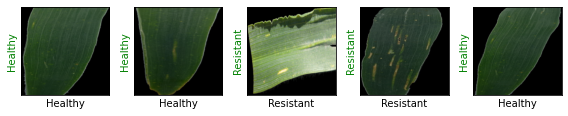

In [18]:
# Call the 'display_prediction_images' function to visualize predictions on the test dataset.
display_prediction_images(testloader)

In [22]:
def train_model(model, epochs, trainloader, testloader, optimizer, loss_fn):
    """
    Train a deep learning model and evaluate it over multiple epochs.

    Args:
    - model: The deep learning model to be trained.
    - epochs (int): The number of training epochs.
    - trainloader (DataLoader): DataLoader for the training dataset.
    - testloader (DataLoader): DataLoader for the validation/test dataset.
    - optimizer: The optimization algorithm used for training.
    - loss_fn: The loss function used for training.

    Returns:
    - metrics (dict): A dictionary containing training and validation metrics.
    """
    # Create a dictionary to store training and validation metrics.
    metrics = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': [], 
               'train_loss_all': [], 'train_acc_all': []}

    # Print a message indicating which model is being trained.
    print("Training {} model".format(model.__class__.__name__))

    train_step = 0

    # Loop through each training epoch.
    for e in range(0, epochs):
        print()
        print("Epoch {} of {}".format(e + 1, epochs))

        train_loss = 0.
        val_loss = 0.
        
        # Set the model to training mode.
        model.train()

        # Loop through each batch of the training dataset.
        for batch_no, (images, labels) in enumerate(trainloader):
            if (torch.cuda.is_available()):
                images = images.cuda()
                labels = labels.cuda()
            train_step += 1
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()
            train_loss += loss.item()
            
            _, train_preds = torch.max(outputs, 1)
            train_acc = sum((train_preds == labels).cpu().numpy())
            
            metrics['train_loss_all'].append(train_loss / (train_step + 1))
            metrics['train_acc_all'].append(train_acc / (train_step + 1))
            
            # Evaluate the model every 20th batch.
            if batch_no % 20 == 0:
                print("Trained till batch {}".format(batch_no))

        metrics['train_loss'].append(train_loss / (train_step + 1))
        metrics['train_accuracy'].append(train_acc / (train_step + 1))
        
        # Evaluate the model on the validation dataset.
        print("Evaluating at Epoch ", e)
        accuracy = 0
        model.eval()

        for val_step, (images, labels) in enumerate(testloader):
            if (torch.cuda.is_available()):
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            accuracy += sum((preds == labels).cpu().numpy())

        val_loss /= (val_step + 1)
        accuracy = accuracy / (len(testset) / 5)
        print("Validation Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss, accuracy))

        metrics['valid_loss'].append(val_loss)
        metrics['valid_accuracy'].append(accuracy)

        # Display prediction images for visual inspection.
        display_prediction_images(testloader)

        # Set the model back to training mode.
        model.train()

        # If a desired accuracy is achieved, stop training early.
        if accuracy >= 0.999:
            print('Optimal Accuracy Attained. Stopping now!')
            train_loss /= (train_step + 1)
            print("Training Loss {:.4f}".format(train_loss))
            return metrics

    return metrics

Training ResNet model

Epoch 1 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  0
Validation Loss: 0.0592, Accuracy: 0.9783


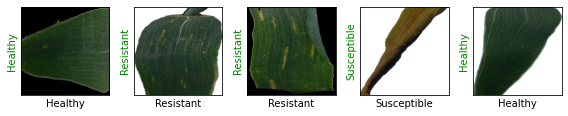


Epoch 2 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  1
Validation Loss: 0.0416, Accuracy: 0.9905


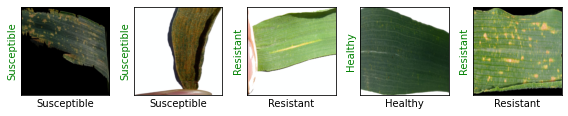


Epoch 3 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  2
Validation Loss: 0.0340, Accuracy: 0.9891


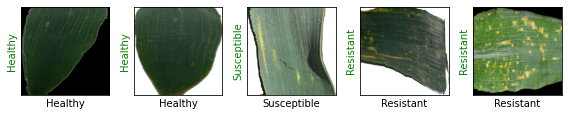


Epoch 4 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  3
Validation Loss: 0.0414, Accuracy: 0.9905


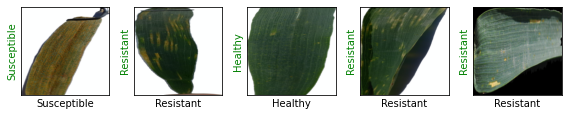


Epoch 5 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  4
Validation Loss: 0.0529, Accuracy: 0.9823


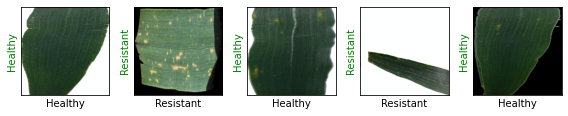


Epoch 6 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  5
Validation Loss: 0.0338, Accuracy: 0.9878


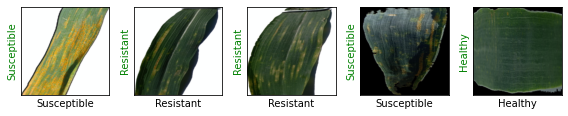


Epoch 7 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  6
Validation Loss: 0.0480, Accuracy: 0.9891


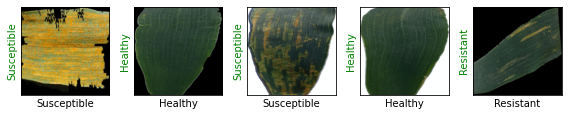


Epoch 8 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  7
Validation Loss: 0.0370, Accuracy: 0.9918


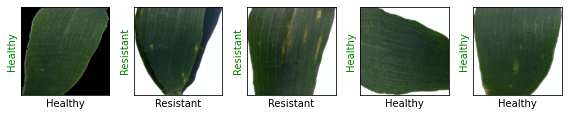


Epoch 9 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  8
Validation Loss: 0.0309, Accuracy: 0.9946


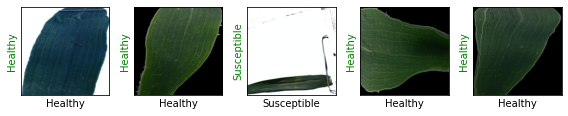


Epoch 10 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  9
Validation Loss: 0.0341, Accuracy: 0.9905


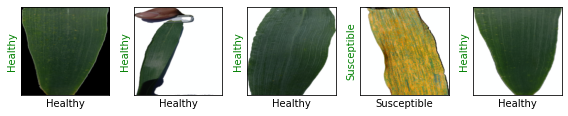

In [24]:
# Train the model for 10 epochs using the specified training and testing data loaders,
# optimizer, and loss function. Collect training and validation metrics.
metrics = train_model(model, 10, trainloader, testloader, optimizer, loss_fn)

In [25]:
# Save the state dictionary (weights and parameters) of the model to a file.
torch.save(model.state_dict(), "resnet18_2dataC_model.pt")

In [26]:
def test_model(testloader, model, loss_fn):
    """
    Test a trained deep learning model on a test dataset.

    Args:
    - testloader (DataLoader): DataLoader for the test dataset.
    - model: The trained deep learning model to be tested.
    - loss_fn: The loss function used for testing.

    Returns:
    - test_metrics (dict): A dictionary containing test metrics, including true labels and predictions.
    """
    # Print a message indicating which model is being tested.
    print("Testing {} model".format(model.__class__.__name__))

    # Create a dictionary to store test metrics, including true labels and predictions.
    test_metrics = {'labels': [], 'predictions': []}

    # Initialize variables to calculate test loss and accuracy.
    test_loss = 0.
    correct = 0.
    total = 0.

    # Set the model to evaluation mode.
    model.eval()

    # Loop through each batch in the test dataset.
    for batch_idx, (images, target) in enumerate(testloader):
        if (torch.cuda.is_available()):
            images = images.cuda()
            target = target.cuda()

        # Add true labels to the test metrics.
        test_metrics['labels'] += list(target)

        # Get model predictions and calculate the test loss.
        outputs = model(images)
        loss = loss_fn(outputs, target)

        # Update the average test loss.
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        # Convert output probabilities to predicted class labels.
        pred = outputs.data.max(1, keepdim=True)[1]

        # Add model predictions to the test metrics.
        test_metrics['predictions'] += list(pred)

        # Compare predictions to true labels and update correct and total counts.
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += images.size(0)

    # Print the test loss and accuracy.
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %.3f%% (%2d/%2d)' % (100. * correct / total, correct, total))

    # Return the test metrics, including true labels and predictions.
    return test_metrics


In [27]:
# Evaluate the trained model on the test dataset and collect test metrics.
test_metrics = test_model(testloader, model, loss_fn)

Testing ResNet model
Test Loss: 0.034542


Test Accuracy: 99.049% (729/736)


In [28]:
# Convert test metrics' labels and predictions to integer lists for further analysis.
labs = [int(x) for x in test_metrics['labels']]
preds = [int(x) for x in test_metrics['predictions']]

In [29]:
# Calculate the accuracy score between true labels and predicted labels.
accuracy = accuracy_score(labs, preds)

0.9904891304347826

In [30]:
# Print a classification report to assess the model's performance.
print(classification_report(labs, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       275
           1       0.98      0.98      0.98       199
           2       1.00      0.98      0.99       262

    accuracy                           0.99       736
   macro avg       0.99      0.99      0.99       736
weighted avg       0.99      0.99      0.99       736



<AxesSubplot:title={'center':'Confusion Matrix'}>

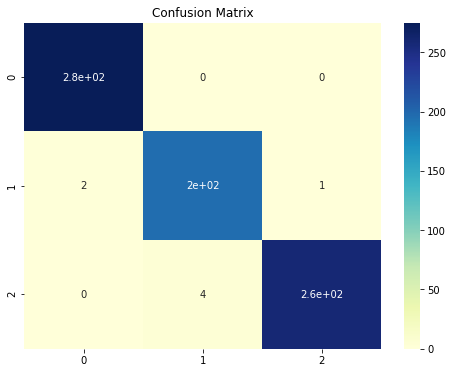

In [31]:
# Generate a confusion matrix and display it as a heatmap.
confusion_mat = confusion_matrix(labs, preds)

# Create a figure for visualization.
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")

# Generate a heatmap of the confusion matrix with annotations.
sns.heatmap(confusion_mat, cmap="YlGnBu", annot=True)


## Resnet 50

In [13]:
model = resnet50(pretrained=True)

In [14]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [15]:
model.fc = torch.nn.Linear(in_features=2048, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

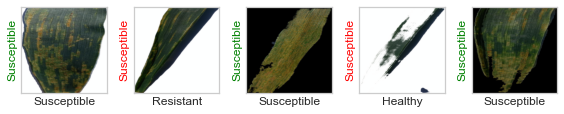

In [21]:
display_prediction_images(testloader)

Training ResNet model

Epoch 1 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  0
Validation Loss: 0.1355, Accuracy: 0.9552


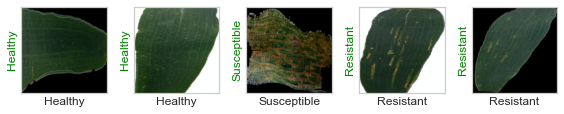


Epoch 2 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  1
Validation Loss: 0.1109, Accuracy: 0.9701


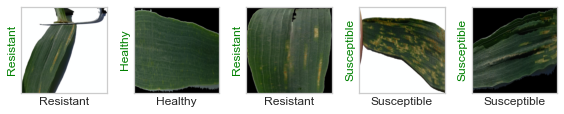


Epoch 3 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  2
Validation Loss: 0.0610, Accuracy: 0.9728


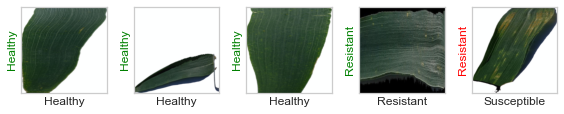


Epoch 4 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  3
Validation Loss: 0.0432, Accuracy: 0.9891


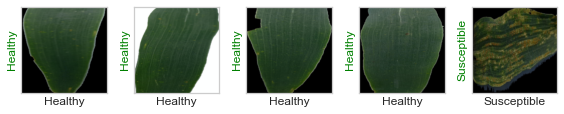


Epoch 5 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  4
Validation Loss: 0.0436, Accuracy: 0.9878


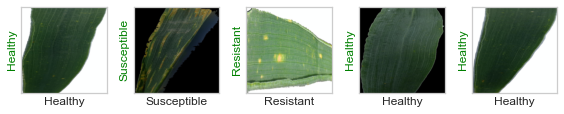


Epoch 6 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  5
Validation Loss: 0.0656, Accuracy: 0.9796


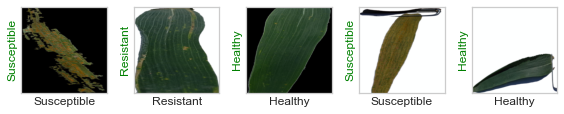


Epoch 7 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  6
Validation Loss: 0.0568, Accuracy: 0.9837


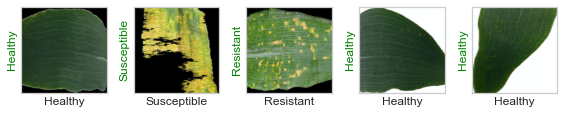


Epoch 8 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  7
Validation Loss: 0.0365, Accuracy: 0.9851


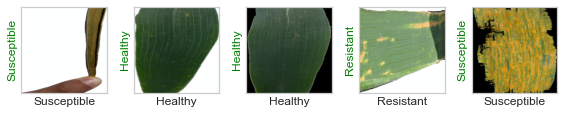


Epoch 9 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  8
Validation Loss: 0.0435, Accuracy: 0.9837


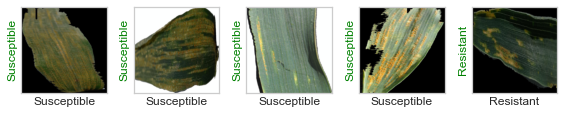


Epoch 10 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  9
Validation Loss: 0.0578, Accuracy: 0.9810


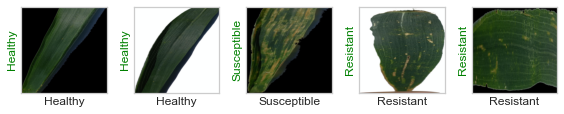

In [23]:
metrics = train_model(model, 10, trainloader, testloader, optimizer, loss_fn)

In [24]:
#torch.save(model.state_dict(), "resnet50_Comparison10e.pt")

In [27]:
import pickle

with open('model_comparison/resnet50_trainMetrics.obj', 'wb') as fp:
    pickle.dump(metrics, fp)

In [26]:
test_metrics = test_model(testloader, model, loss_fn)

Testing ResNet model
Test Loss: 0.057751


Test Accuracy: 98.098% (722/736)


In [28]:
import pickle

with open('model_comparison/resnet50_testMetrics.obj', 'wb') as fp:
    pickle.dump(test_metrics, fp)

In [29]:
labs = [int(x) for x in test_metrics['labels']]
preds = [int(x) for x in test_metrics['predictions']]

In [30]:
accuracy_score(labs, preds)

0.9809782608695652

In [31]:
print(classification_report(labs, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       267
           1       0.98      0.95      0.97       206
           2       0.97      0.99      0.98       263

    accuracy                           0.98       736
   macro avg       0.98      0.98      0.98       736
weighted avg       0.98      0.98      0.98       736



<AxesSubplot:title={'center':'Confusion Matrix'}>

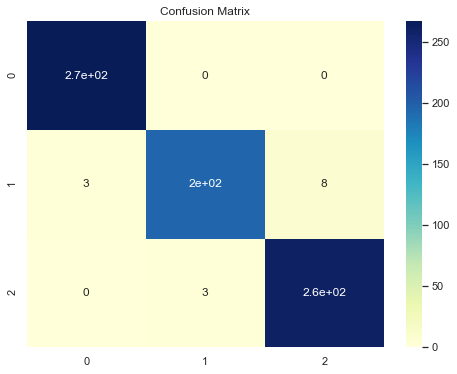

In [32]:
confusion_mat =  confusion_matrix(labs, preds)
plt.figure(figsize=(8,6))
plt.title("Confusion Matrix")
sns.heatmap(confusion_mat,cmap="YlGnBu", annot=True)

## Alexnet

In [12]:
model = alexnet(pretrained=True)

In [13]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [15]:
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=3)

In [16]:
#model.fc = torch.nn.Linear(in_features=2048, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


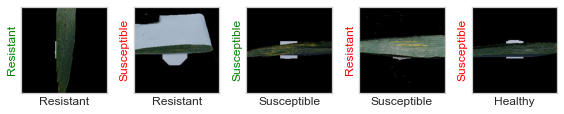

In [21]:
display_prediction_images(testloader)

Training AlexNet model

Epoch 1 of 10


C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  0
Validation Loss: 0.1555, Accuracy: 0.9389


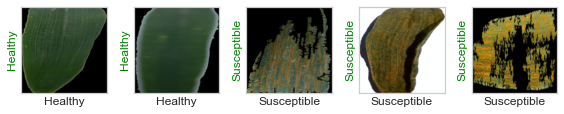


Epoch 2 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  1
Validation Loss: 0.1313, Accuracy: 0.9497


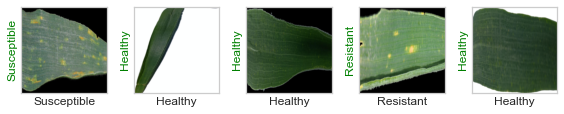


Epoch 3 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  2
Validation Loss: 0.2046, Accuracy: 0.9470


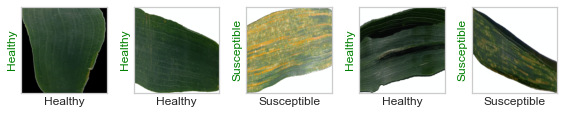


Epoch 4 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  3
Validation Loss: 0.1505, Accuracy: 0.9429


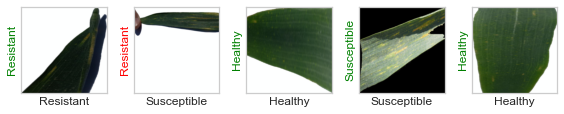


Epoch 5 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  4
Validation Loss: 0.0799, Accuracy: 0.9769


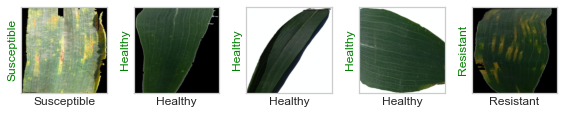


Epoch 6 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  5
Validation Loss: 0.1503, Accuracy: 0.9511


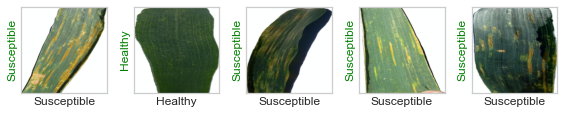


Epoch 7 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  6
Validation Loss: 0.1019, Accuracy: 0.9742


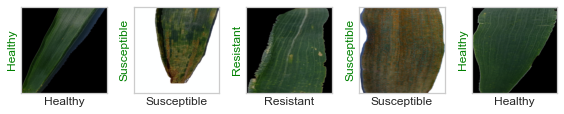


Epoch 8 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  7
Validation Loss: 0.0642, Accuracy: 0.9810


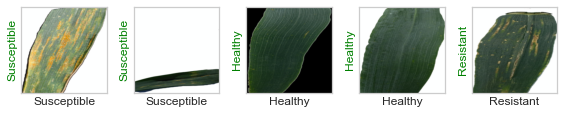


Epoch 9 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  8
Validation Loss: 0.1429, Accuracy: 0.9606


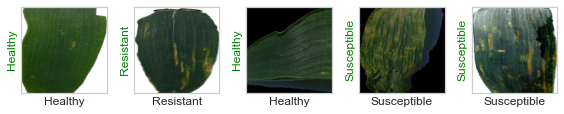


Epoch 10 of 10
Trained till batch 0
Trained till batch 20
Trained till batch 40
Trained till batch 60
Trained till batch 80
Trained till batch 100
Trained till batch 120
Trained till batch 140
Trained till batch 160
Trained till batch 180
Trained till batch 200
Trained till batch 220
Trained till batch 240
Trained till batch 260
Trained till batch 280
Trained till batch 300
Trained till batch 320
Trained till batch 340
Trained till batch 360
Trained till batch 380
Trained till batch 400
Trained till batch 420
Trained till batch 440
Trained till batch 460
Trained till batch 480
Trained till batch 500
Trained till batch 520
Trained till batch 540
Trained till batch 560
Trained till batch 580
Evaluating at Epoch  9
Validation Loss: 0.1105, Accuracy: 0.9715


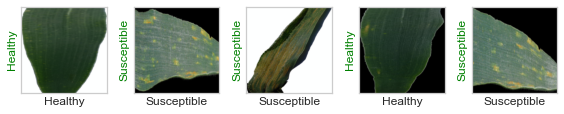

In [22]:
metrics = train_model(model, 10, trainloader, testloader, optimizer, loss_fn)

In [23]:
torch.save(model.state_dict(), "alexnet_Comparison10e.pt")

In [24]:
import pickle

with open('model_comparison/alexnet_trainMetrics.obj', 'wb') as fp:
    pickle.dump(metrics, fp)

In [27]:
test_metrics = test_model(testloader, model, loss_fn)

Testing AlexNet model
Test Loss: 0.111380


Test Accuracy: 96.875% (713/736)


In [28]:
import pickle

with open('model_comparison/alexnet_testMetrics.obj', 'wb') as fp:
    pickle.dump(test_metrics, fp)

In [29]:
labs = [int(x) for x in test_metrics['labels']]
preds = [int(x) for x in test_metrics['predictions']]

In [30]:
accuracy_score(labs, preds)

0.96875

In [31]:
print(classification_report(labs, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       268
           1       0.97      0.93      0.95       187
           2       0.96      0.97      0.97       281

    accuracy                           0.97       736
   macro avg       0.97      0.96      0.97       736
weighted avg       0.97      0.97      0.97       736



<AxesSubplot:title={'center':'Confusion Matrix'}>

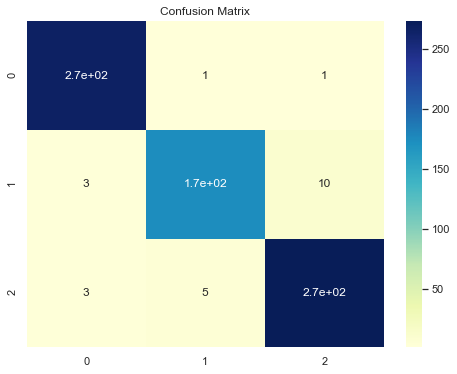

In [32]:
confusion_mat =  confusion_matrix(labs, preds)
plt.figure(figsize=(8,6))
plt.title("Confusion Matrix")
sns.heatmap(confusion_mat,cmap="YlGnBu", annot=True)